# IMPORTS

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# LOAD DATASET

In [14]:
import torch
from torchvision import datasets, transforms

# Define the transform to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the train dataset
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers= 8)

# Load the test dataset
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers= 8)



# ENCODER

In [15]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(32 * 7 * 7, 256)
        self.mulayer = nn.Linear(256, latent_dim)
        self.varlayer = nn.Linear(256, latent_dim)

    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.view(-1, 32 * 7 * 7)
        x = self.fc(x)
        x = F.relu(x)
      
        mu = self.mulayer(x)
        logvar = self.varlayer(x)
        return mu, logvar

# DECODER

In [16]:
# Define the decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 32 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        
        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc2(x)
        x=F.relu(x)
        x=x.view(-1, 32, 7, 7)
        x=self.conv1(x)
        x= F.relu(x)
        x=self.conv2(x)
        x = F.sigmoid(x)
        
        return x

# Variational AutoEncoder

In [17]:
# Define the VAE
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# Loss Function

In [18]:
def loss_function(x_recon, x, mu, logvar):
    # Reconstruction loss
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')

    # KL divergence regularization
    KLD = -0.2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    loss = BCE + KLD

    return loss

# SET UP MODEL

In [19]:
LEARNING_RATE=1e-3
NUM_EPOCHS = 5

criterion = nn.MSELoss()
vae = VAE(latent_dim=100)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

# TRAINING LOOP

In [20]:


for epoch in range(NUM_EPOCHS):
    # Set the model to training mode


    train_loss = 0
    mse_train_loss=0

    # Iterate over the training data
    for batch_idx, (data, _) in enumerate(trainloader):
        #data = data.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        recon_data, mu, logvar = vae(data)
        # Compute the loss
        loss = loss_function(recon_data, data, mu, logvar)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        train_loss += loss.item()

        #print(f"data.shape : {data.shape}")
        #print(f"recon_data.shape : {recon_data.shape}")

        mseloss = criterion(data, recon_data)*data.size(0)
        mse_train_loss += mseloss.item()



    # Compute the average loss for the epoch
    train_loss /= len(trainloader.dataset)
    mse_train_loss /= len(trainloader.dataset)


    print('Epoch: {} TOTAL Train loss: {:.4f}'.format(epoch+1, train_loss)) 
    print('Epoch: {} Train MSE loss: {:.4f}'.format(epoch+1, mse_train_loss))


Epoch: 1 Train loss: -38103.8294
Epoch: 1 Train MSE loss: 0.9412
Epoch: 2 Train loss: -52228.7921
Epoch: 2 Train MSE loss: 0.9231
Epoch: 3 Train loss: -56843.3834
Epoch: 3 Train MSE loss: 0.9129
Epoch: 4 Train loss: -59818.4170
Epoch: 4 Train MSE loss: 0.8887
Epoch: 5 Train loss: -61378.5771
Epoch: 5 Train MSE loss: 0.8728


# TRAIN & TEST SET MSE 

In [21]:
# Evaluate the model
vae.eval()

total_train_loss = 0.0
with torch.no_grad():
    # Loop over the test data
    for i, (inputs, labels) in enumerate(trainloader):
        #inputs = inputs.to(device)                  # Needed for CUDA
        outputs,_,_ = vae(inputs)                       # Pass images through Autoencoder
        loss = criterion(outputs, inputs)           # MSE Loss
        total_train_loss += loss.item() * inputs.size(0)  # Remove 1/n factor

avg_loss = total_train_loss / len(trainset)
print('Average Test Loss: {:.4f}'.format(avg_loss))


total_test_loss = 0.0
with torch.no_grad():
    # Loop over the test data
    for i, (inputs, labels) in enumerate(testloader):
        #inputs = inputs.to(device)                  # Needed for CUDA
        outputs,_,_ = vae  (inputs)                     # Pass images through Autoencoder
        loss = criterion(outputs, inputs)           # MSE Loss
        total_test_loss += loss.item() * inputs.size(0)  # Remove 1/n factor

avg_loss = total_test_loss / len(testset)
print('Average Test Loss: {:.4f}'.format(avg_loss))



Average Test Loss: 0.8675
Average Test Loss: 0.8655


In [22]:
total_test_loss = 0.0
all_test_data = []
all_test_data_processed = []

with torch.no_grad():
    # Loop over the test data
    for i, (inputs, labels) in enumerate(testloader):
        #inputs = inputs.to(device)                       # Needed for CUDA
        outputs,_,_ = vae(inputs)                          # Pass images through Autoencoder
        loss = criterion(outputs, inputs)                # MSE Loss
        total_test_loss += loss.item() * inputs.size(0)  # Remove 1/n factor
        
        all_test_data.append(inputs)
        all_test_data_processed.append(outputs)
        
avg_loss = total_test_loss / len(testset)
print('Average Test Loss: {:.4f}'.format(avg_loss))


# Concatenate the encoded test data into a single tensor
all_test_data = torch.cat(all_test_data, dim=0)
all_test_data_processed = torch.cat(all_test_data_processed, dim=0)


Average Test Loss: 0.8655


# PLOT BATCH  TO VISUALISE OUTPUT

In [23]:
def plot_batch(batch_input_images, batch_output_images,num_images=64):
    
    import matplotlib.pyplot as plt
    import numpy as np
    from torchvision.utils import make_grid
    
    # Grid from batch
    grid_in = make_grid(batch_input_images[:num_images])
    grid_out = make_grid(batch_output_images[:num_images])
    
    # Convert the grid to a numpy array and transpose the dimensions
    grid_in = grid_in.numpy().transpose((1, 2, 0))
    grid_out = grid_out.numpy().transpose((1, 2, 0))
    
    # Denormalize the pixel values
    grid_in = (grid_in - grid_in.min()) / (grid_in.max() - grid_in.min())
    grid_out = (grid_out - grid_out.min()) / (grid_out.max() - grid_out.min())
    
    # Subplots to see result side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    ax1.imshow(grid_in)
    ax1.set_title("Original Dataset", fontsize=40)
    
    ax2.imshow(grid_out)
    ax2.set_title("Output Dataset", fontsize=40)
   

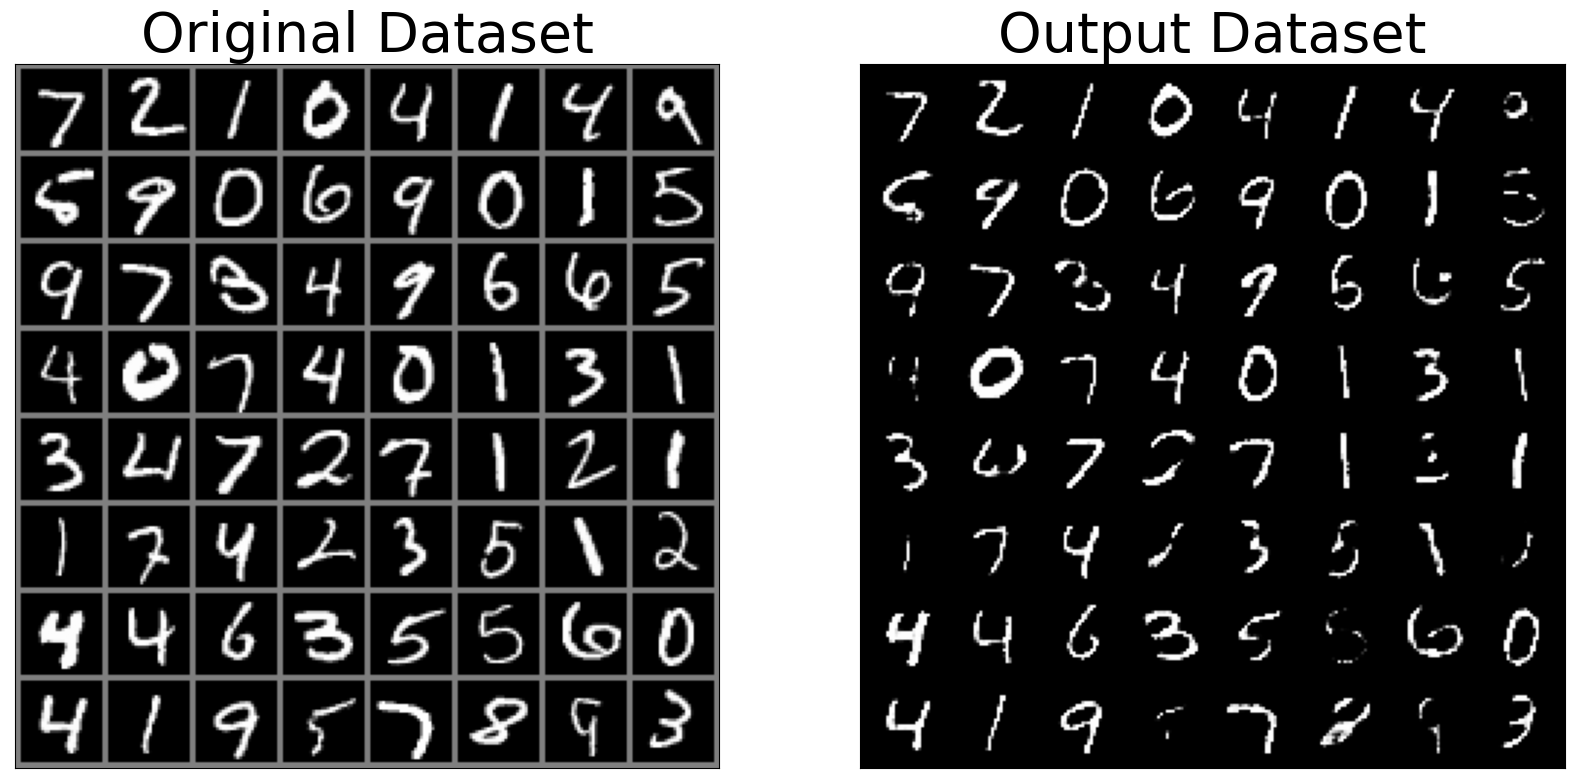

In [24]:
batch_input_images, labels = next(iter(testloader)) # 1st batch of test set
#batch_input_images = batch_input_images.to(device) # Do this if trained on CUDA
batch_output_images,_,_ = vae(batch_input_images)   # Pass batch trough model 

batch_output_images = batch_output_images.cpu()     # Needs this for matplotlib
batch_input_images = batch_input_images.cpu()       # Needs this for matplotlib

plot_batch(batch_input_images, batch_output_images,num_images=64)

In [ ]:
img,_ = next(iter(testloader))

In [ ]:
e = Encoder(latent_dim = 10)

In [ ]:
mu,lv=e(img)

In [ ]:
img.shape

In [ ]:
mu.shape

In [ ]:
lv.shape

In [ ]:
d = Decoder(latent_dim=10)

In [ ]:
recon = d(mu)

In [ ]:
recon.shape

In [ ]:
vae = VAE(latent_dim=10)

In [ ]:
x_recon, mu, logvar = vae(img)

In [ ]:
x_recon.shape

In [ ]:
mu.shape

In [ ]:
logvar.shape

In [ ]:
img.shape

In [ ]:
img2 = img

In [ ]:
nn.MSELoss(img,img2)